# Extract the features of the IEA

In this notebook we will use the data recorded with an intracranial EEG device in one person with epilepsy. This device records 1) seizures, visible in the EEG as pathological signals evolving in time and 2) interictal epilepform activity (IEA), evanescent electrical discharges produced by the epileptic brain between seizures. We will show how IEA fluctuates cyclically over days and use a wavelet transform to extract the phase of these "multidien" cycles. We will also compute the phase-locking value (PLV) for the locking of the seizures in the multidien phase.

## Import libraries

For these computations we need to load Python libraries, including a wavelt toolbox.


In [2]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy import signal
import pywt
import datetime as dt
from pandas.plotting import register_matplotlib_converters

## Load the data 

We will load data recorded by the EEG device over years in one patient with epilepsy from a CSV file. The first column contains hourly timestamps of recordings. The second and third column contain counts of seizures and IEA (i.e. the number of detected waveforms) per hour, respectively. The IEA has been normalized by Z-scoring blocks of several weeks of recordings, to account for periods of stable detection settings of the EEG device. 

In [3]:
data = pd.read_csv(r'data/features_day_JE_acausal4.csv')
data

Time  Seizures     IEA_1     IEA_2  CircadianAbs1  \
0    733972.979167         0 -0.688957 -0.824398       1.062300   
1    733973.979167         0 -0.397765 -0.481134       0.925151   
2    733974.979167         2 -0.045270  0.720290       0.647196   
3    733975.979167         0  0.537114  0.319816       0.551267   
4    733976.979167         0 -0.482058 -0.538345       0.767475   
..             ...       ...       ...       ...            ...   
535  734507.979167         1 -0.127745 -0.545234       1.115427   
536  734508.979167         0 -0.576691 -0.545234       0.983173   
537  734509.979167         0 -0.639701 -0.670254       0.988099   
538  734510.979167         0 -0.663330 -0.745266       0.839624   
539  734511.979167         0 -0.222260 -0.395211       0.503807   

     CircadianAngle1  CircadianCos1  CircadianSin1  CircadianFiltSig1  \
0           0.302651       0.954550       0.298052           0.119773   
1           0.052233       0.998636       0.052209          -0.035270   
2          -0.230024       0.973661      -0.228001          -0.022063   
3           0.209761       0.978081       0.208226          -0.025371   
4           0.170185       0.985554       0.169364           0.040485   
..               ...            ...            ...                ...   
535         0.005430       0.999985       0.005430          -0.016796   
536        -0.108773       0.994090      -0.108559          -0.027329   
537        -0.058658       0.998280      -0.058625          -0.019427   
538        -0.020084       0.999798      -0.020082           0.008930   
539        -0.317026       0.950167      -0.311742           0.034325   

     CircadianAbs2  ...  MultidienCos7  MultidienSin7  MultidienFiltSig7  \
0         0.749475  ...       0.744446       0.667682           0.029787   
1         0.830741  ...       0.964069      -0.265653           0.116543   
2         0.192435  ...       0.976613      -0.215003           0.193238   
3         0.098967  ...       0.997251      -0.074096           0.254267   
4         0.422072  ...       0.996082       0.088433           0.295675   
..             ...  ...            ...            ...                ...   
535       1.101473  ...       0.993468       0.114108           0.548256   
536       1.204308  ...       0.939286       0.343135           0.474438   
537       1.241518  ...       0.824040       0.566531           0.363669   
538       1.013170  ...       0.631959       0.775002           0.223788   
539       0.730715  ...       0.301400       0.953498           0.065373   

     MultidienAbs8  MultidienAngle8  MultidienCos8  MultidienSin8  \
0         0.036946        -0.296799       0.956277      -0.292461   
1         0.107939        -0.642337       0.800698      -0.599068   
2         0.167263        -0.532674       0.861452      -0.507839   
3         0.213122        -0.401625       0.920427      -0.390915   
4         0.249645        -0.267405       0.964460      -0.264229   
..             ...              ...            ...            ...   
535       0.366721         0.365830       0.933827       0.357725   
536       0.328287         0.542718       0.856308       0.516465   
537       0.280280         0.734992       0.741836       0.670581   
538       0.219004         0.958782       0.574517       0.818492   
539       0.133596         1.280733       0.286013       0.958226   

     MultidienFiltSig8  meanWeeklySeizures  stdWeeklySeizures  
0             0.013614            0.009809           0.098481  
1             0.074721            0.008465           0.091629  
2             0.132383            0.011279           0.104522  
3             0.184456            0.012681           0.115850  
4             0.229066            0.010870           0.107936  
..                 ...                 ...                ...  
535           0.330746            0.012681           0.115850  
536           0.269407            0.010870           0.107936  
537           

## Raw data

Our raw data is the interictal epilepform activity (IEA). For the subject "JE" we obseve that IEA changes in time with periodic patterns.

<IPython.core.display.Javascript object>


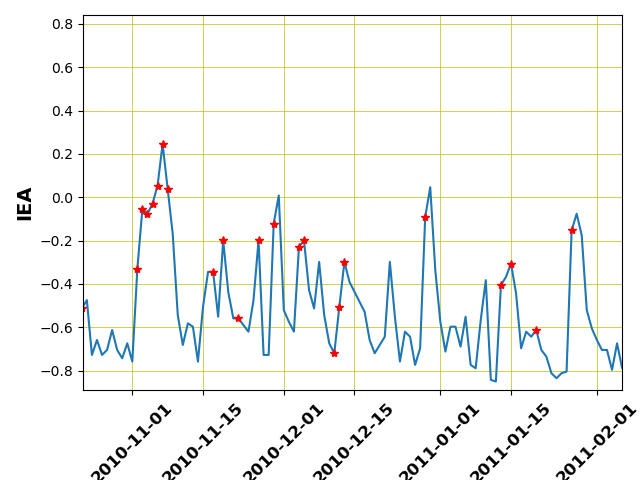

In [6]:
PosSeizJE=np.where(data.Seizures>=1)
TimeDate=data.Time[:].astype(int).map(dt.datetime.fromordinal)
register_matplotlib_converters()

plt.figure()
plt.plot(TimeDate,data.IEA_1)
plt.ylabel('IEA', weight='bold', fontsize=14)
plt.plot(TimeDate.iloc[PosSeizJE],data.IEA_1.iloc[PosSeizJE],'r*')
#plt.xlim((4900, 5100))
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.grid(color = 'y', linewidth='0.5')
plt.tight_layout()
plt.show()

#### Figure
The figure shows the fluctuations of IEA (averaged over one day) over time. We observe that IEA has priodic behaviours. Use the interactive tools of the plot to display one year at a time, then only one month (zoom, square). You can travel on the x-axis using the directional cross. Seizures are plotted as red stars. Pay attention to where in the IEA cycle they tend to occur. In the next sections, we will characterize this phasic relationship between seizures (a point event) and IEA (the continuous variable). We will later use it for forecasting.

## Wavelet transform

As we observe, fluctuations in IEA are periodic, but not necessarily stationary. To capture the instanteneous changes in time, we use a morlet wavelet tranform that can evaluate power and phase of different rhyhtms at each time-point. We focus on multidien cycles which are here defined between 4-45 days. 

<IPython.core.display.Javascript object>


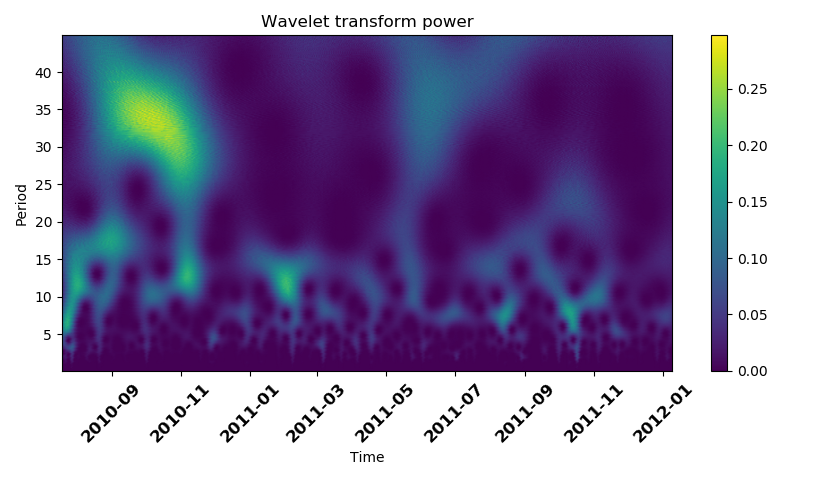

In [5]:
fs=1
scales=np.arange(0.1,45,0.1)
frequencies = pywt.scale2frequency('cmor1.5-1.0', scales) / 1

[coefficients_IEA, frequencies] = pywt.cwt(data.IEA_1, scales,'cmor1.5-1.0',1)
power_IEA = (abs(coefficients_IEA)) ** 2
Periods=1/frequencies

plt.figure(figsize=(8.4, 4.8))
c=plt.pcolormesh(TimeDate,Periods,power_IEA,cmap='viridis', shading='gouraud',vmin = power_IEA.min(), vmax = power_IEA.max())
plt.title('Wavelet transform power')
plt.colorbar(c)
plt.ylabel('Period')
plt.xlabel('Time')
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.tight_layout()
plt.show()

## Peak of the periodogram extraction

We take the peak of the periodogram and extract the phase of that band.

<IPython.core.display.Javascript object>


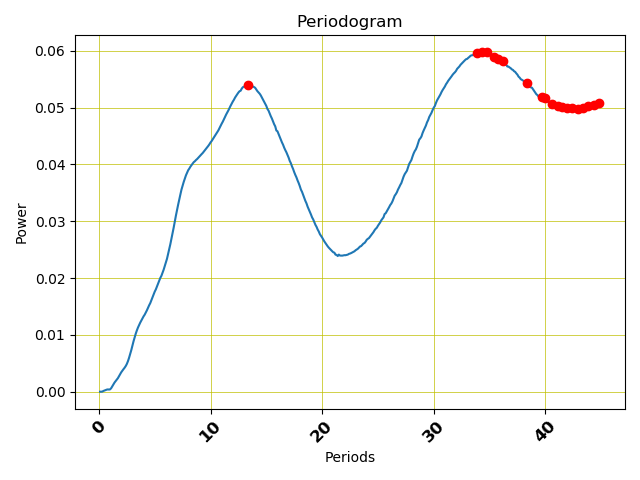

Peak of the periodogram = 35


<IPython.core.display.Javascript object>


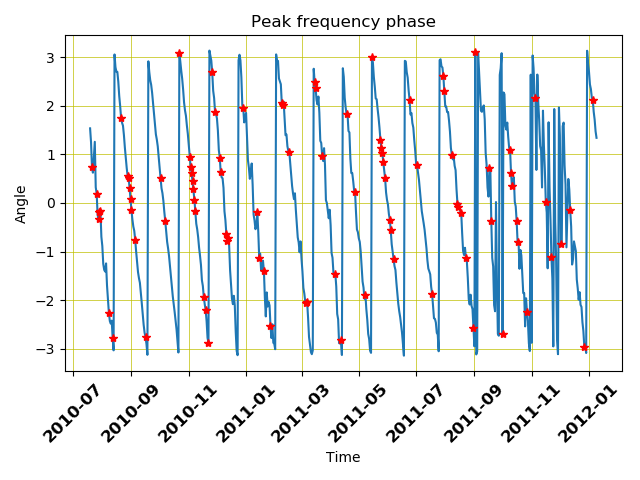

In [6]:
# peak frequency phas extraction
peaks, properties = signal.find_peaks(np.mean(power_IEA,axis=1),np.mean(np.mean(power_IEA,axis=1)))
hights = properties['peak_heights']
# Periodogram
Periodo=np.mean(power_IEA,axis=1)

plt.figure()
plt.title('Periodogram')
plt.plot(Periods,Periodo)
plt.plot(Periods[peaks],Periodo[peaks],'ro')
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.grid(color = 'y', linewidth='0.5')
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.xlabel('Periods')
plt.ylabel('Power')
plt.tight_layout()
plt.show()
print('Peak of the periodogram = %0.0f' %(Periods[peaks[np.argmax(hights)]]))
# take the peak of the periodogram
angle_peak_IEA=np.angle(coefficients_IEA[peaks[np.argmax(hights)],:])

plt.figure()
plt.title('Peak frequency phase')
plt.plot(TimeDate,angle_peak_IEA)
plt.plot(TimeDate.iloc[PosSeizJE],angle_peak_IEA[PosSeizJE],'r*')
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.grid(color = 'y', linewidth='0.5')
plt.xlabel('Time')
plt.ylabel('Angle')
plt.tight_layout()
plt.show()



## PLV value and polar histogram

We compute the phase locking value (PLV) of the seizures on the phase of the multidien cycle.

In [7]:
def PLVcalculation(phase):
    z=sum(np.exp(1j*phase))/len(phase)
    PLV=np.abs(z)
    Psi=np.angle(z)
    return PLV,Psi

phase_IEA=angle_peak_IEA[PosSeizJE]
PLV,Psi=PLVcalculation(phase_IEA)


We plot the polar histogram along with the PLV. Note the mean phase locking.

<IPython.core.display.Javascript object>


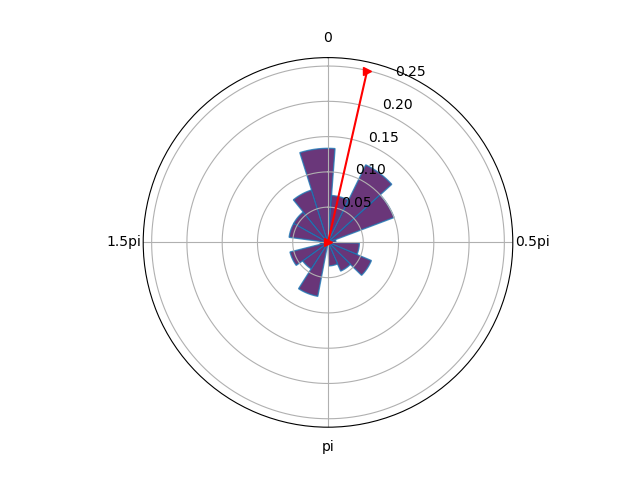

In [8]:
bins=16
num, bins = np.histogram(angle_peak_IEA[PosSeizJE], bins=bins)
widths = np.diff(bins)
radius = num/len(PosSeizJE[0])
# Plot the data
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection='polar'))
patches = ax.bar(bins[:-1], radius, zorder=1, align='edge', width=widths,
                 edgecolor='C0', fill=True, linewidth=1,alpha=0.3)

lines, labels = plt.thetagrids(range(0, 360, 90), ('0', '0.5pi', 'pi', '1.5pi'))
for r, bar in zip(radius, patches):
    bar.set_facecolor(plt.cm.viridis(r / 10.))
    bar.set_alpha(0.8)
ax.plot([0 ,Psi],[0,PLV],'r->')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1) 


plt.show()